<center><image src="https://drive.google.com/uc?id=1n3G4TdK_u6PQHcLrxB_A0HijNdigXmUH">

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


In [1]:
!pip install torchmetrics segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!gdown --folder 1EX0RW1TRQVkLmR1h6miCQqyhYPFyg28M

Retrieving folder contents
Processing file 1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC labels.pt
Processing file 1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I logits.pt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1--WxvBdpMn_NOmYPf3a4au8MHzfx5baC
To: /content/for_asserts/labels.pt
100% 1.18k/1.18k [00:00<00:00, 4.94MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0A7_CS_vKiSCkgIDJ4joThCEcFedA3I
To: /content/for_asserts/logits.pt
100% 1.18k/1.18k [00:00<00:00, 4.42MB/s]
Download completed


In [3]:
!gdown 1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql

Downloading...
From (original): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql
From (redirected): https://drive.google.com/uc?id=1T_RPkPP0jeWwK8L1UrmBw8V30eD7v6Ql&confirm=t&uuid=6d529376-60e6-4412-8343-d2e8758b75e6
To: /content/PH2Dataset.rar
100% 162M/162M [00:04<00:00, 39.3MB/s]


In [4]:
from skimage.transform import resize
from skimage.io import imread
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.utils.data import DataLoader
import torch
from torchmetrics import JaccardIndex
import torch.nn.functional as F
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
from tqdm.notebook import tqdm
from torchmetrics.segmentation  import DiceScore
from segmentation_models_pytorch.losses import DiceLoss
from torchvision.ops import sigmoid_focal_loss

# Загрузка данных

1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>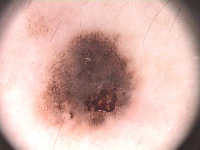</td><td>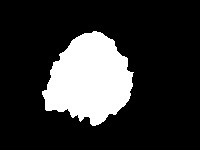</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [5]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs,files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

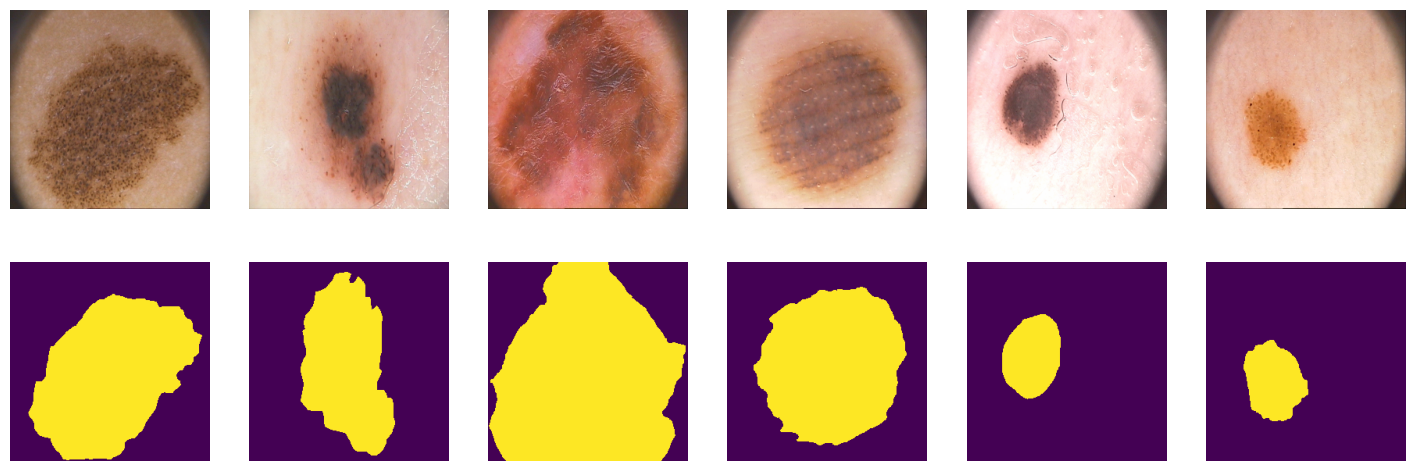

In [9]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [10]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


## PyTorch DataLoader

In [12]:
batch_size = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

# Построй свой первый бейзлайн!

Итак, загрузка файлов, код датасета и даталоадера написана за вас. Метрика IoU написана за вас! Вам остается написать лосс, модель и функции обучения и теста модели.

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]

## BCE Loss [2 балла]

Популярным лоссом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

### Вывод численно стабильной формулы BCE лосса [1 балл]



Выведите из формулы [1] формулу [2]:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right] \space [1]$$

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right) \space [2]$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

**Ответ:**

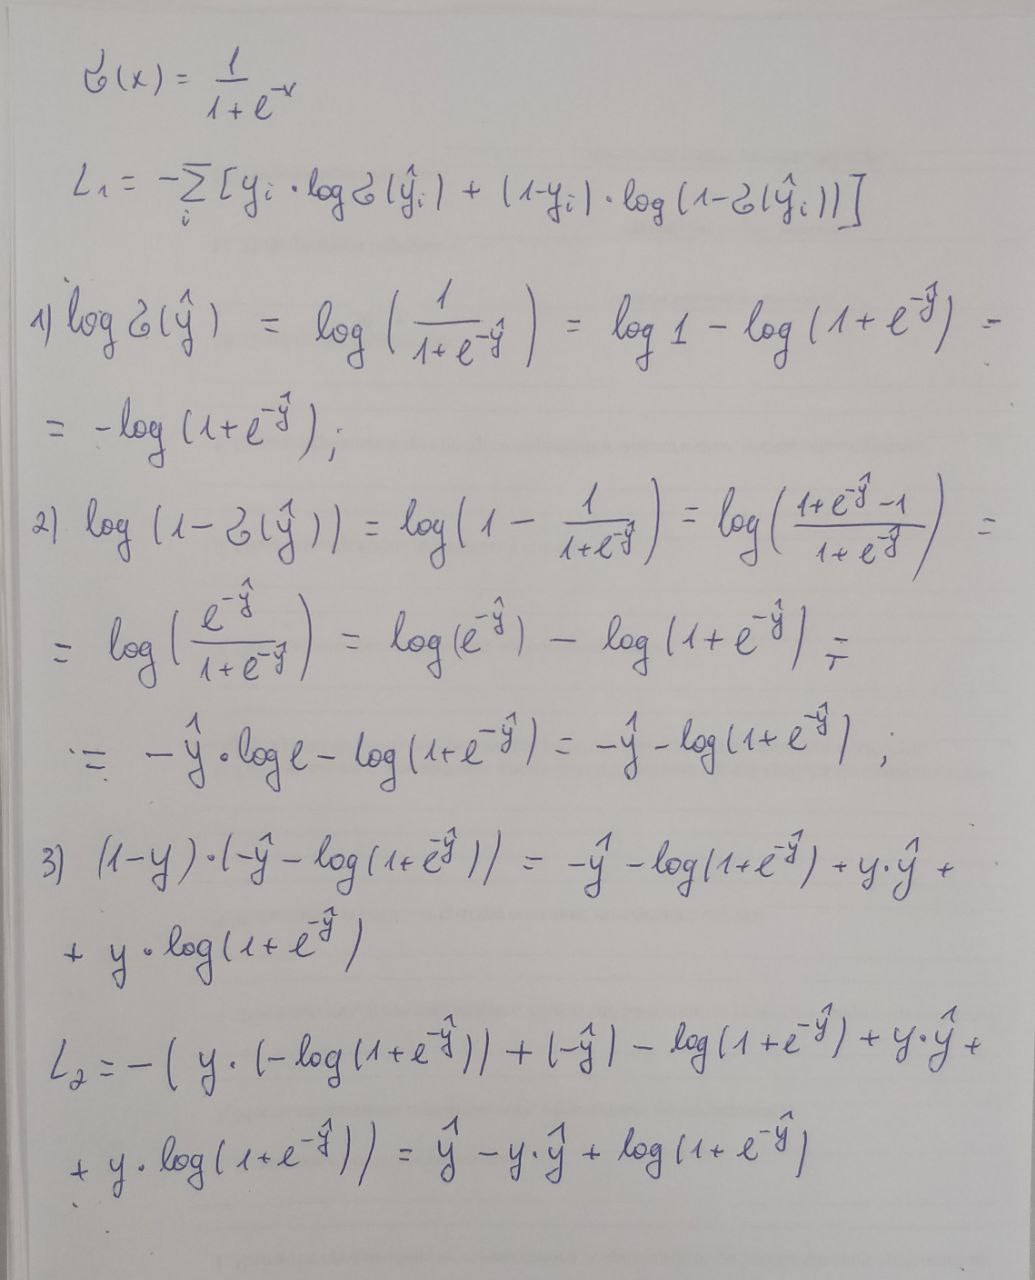

### Реализуйте в коде оба варианта лосса [1 балл]

Реализуйте следующие функции:

*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

И сравните результаты функций с реализацией Pytorch:
*   `bce_torch()`
*   `bce_torch_with_logits()`

In [14]:
bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

In [15]:
def bce_loss(y_pred, y_real):
  return torch.sum(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))

def bce_true(y_pred, y_real):
  return - torch.sum(y_real * torch.log(torch.sigmoid(y_pred))+(1-y_real)*torch.log(1-torch.sigmoid(y_pred)))

Проверим корректность работы на простом примере

In [16]:
y_pred = torch.randn(3, 2, requires_grad=False)
y_true = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true)}')


BCE loss from scratch bce_loss = 4.451801776885986
BCE loss честно посчитанный = 4.451801300048828
BCE loss from torch bce_torch = 4.451801300048828
BCE loss from torch with logits bce_torch = 4.451801300048828


Инструкции `assert` в Python — это булевы выражения, которые проверяют, является ли условие истинным (`True`). Внизу в коде мы проверяем функция `bce_loss()` выдает тот же результат, что и функция из Pytorch или нет. Если равенства не будет, что будет означать, что результаты функций не совпадают, а значит вы неправильно реализовали фукнцию `bce_loss()`, `assert` возвратит ошибку.

Функция `numpy.isclose()` используется для сравнения двух чисел с учётом допустимой погрешности. Она особенно полезна при работе с числами с плавающей точкой, где точное сравнение может быть проблематичным из-за ограничений представления таких чисел в компьютере.

Как она работает?

`numpy.isclose(a, b, rtol=1e-05, atol=1e-08) `принимает два числа (`a` и `b`) и сравнивает их, учитывая относительную и абсолютную погрешность. Если разница между двумя числами меньше заданного порога, функция возвращает `True`, иначе — `False`.

Параметры:

    rtol: Относительная погрешность (по умолчанию 1e-05). Используется для определения разницы относительно большего значения.
    atol: Абсолютная погрешность (по умолчанию 1e-08). Определяет минимальную разницу, которую следует учитывать.

Мы будем использовать `assert` и `numpy.isclose()` для проверки корректности нашего кода.

In [17]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true))

Давайте теперь посчитаем на простом примере, но с теми же размерностями, что и в датасете

In [18]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 15.496350288391113
BCE loss честно посчитанный = 15.496352195739746
BCE loss from torch bce_torch = 15.496352195739746
BCE loss from torch with logits bce_torch = 15.496350288391113


In [19]:
assert np.isclose(bce_loss(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_loss(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float)))
assert np.isclose(bce_true(y_pred, y_true), bce_torch_with_logits(y_pred, y_true.to(torch.float)))

Давайте посчитаем на реальных логитах и сегментационной маске:

In [20]:
path_to_dummy_samples = '/content/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

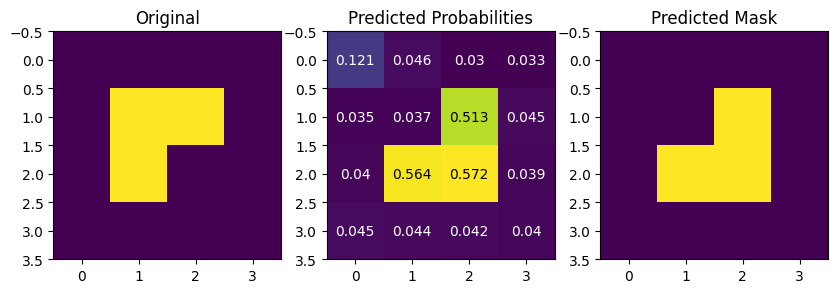

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

Проверяем на данном примере:

In [22]:
bce_loss_score = bce_loss(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_true_score = bce_true(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu())
bce_torch_score = bce_torch(torch.sigmoid(dummpy_sample['logits'].cpu()), dummpy_sample['labels'].cpu().float())
bce_torch_with_logits_score = bce_torch_with_logits(dummpy_sample['logits'].cpu(), dummpy_sample['labels'].cpu().float())
assert np.isclose(bce_loss_score, bce_torch_score)
assert np.isclose(bce_loss_score, bce_torch_with_logits_score)
assert np.isclose(bce_true_score, bce_torch_score)
assert np.isclose(bce_true_score, bce_torch_with_logits_score)

## SegNet [2 балла]

Ваше задание здесь состоит в том, чтобы реализовать SegNet архитектуру.

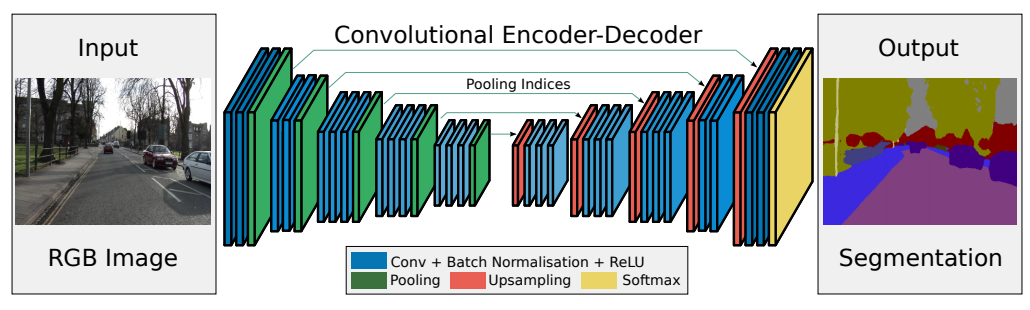

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [23]:
rcParams['figure.figsize'] = (15,4)

In [24]:
class ConvRelu(nn.Module):
    def __init__(self, in_features, out_channels,kernel_size=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_features,out_channels=out_channels, kernel_size=kernel_size, padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):

        x = self.conv(x)

        x = self.norm(x)
        x = self.relu(x)
        return x

In [25]:
class EncoderBlock(nn.Module):
    def __init__(self, in_features, out_channels, depth = 2, kernel_size=3, padding=1):
        super(EncoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(depth):
            self.layers.append(ConvRelu(in_features=(in_features if i==0 else out_channels),out_channels=out_channels,kernel_size=kernel_size,padding=padding))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x,idx = self.pool(x)

        return x, idx

In [26]:
class DecoderBlock(nn.Module):
    def __init__(self, in_features, out_channels, depth=2,kernel=3, padding=1, is_classification = False):
        super(DecoderBlock, self).__init__()
        self.layers = nn.ModuleList()
        self.unpool = nn.MaxUnpool2d(kernel_size=2,stride=2)
        for i in range(depth):
            if is_classification and i==depth-1:
                self.layers.append(nn.Conv2d(in_channels=in_features,out_channels=out_channels,kernel_size=kernel,padding = padding))
            elif i == depth-1:
                self.layers.append(ConvRelu(in_features=in_features, out_channels=out_channels,kernel_size=kernel,padding=padding))
            else:
                self.layers.append(ConvRelu(in_features=in_features,out_channels=in_features,kernel_size=kernel,padding=padding))


    def forward(self,x,idx):
        x = self.unpool(x,idx)
        for layer in self.layers:
            x = layer(x)
        return x

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [27]:
class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        features = 64

        # VGG-16 architecture
        self.enc0 = EncoderBlock(in_features=in_channels,out_channels=features)
        self.enc1 = EncoderBlock(features,features*2)
        self.enc2 = EncoderBlock(features*2,features*4, depth=3)
        self.enc3 = EncoderBlock(features*4,features*8, depth=3)

        # bottleneck
        self.b0 = EncoderBlock(features*8,features*8,depth=3)
        self.b1 = DecoderBlock(features*8,features*8,depth=3)

        # decoder (upsampling)
        self.dec0 = DecoderBlock(features*8,features*4,depth=3)
        self.dec1 = DecoderBlock(features*4,features*2,depth=3)
        self.dec2 = DecoderBlock(features*2,features)
        self.dec3 = DecoderBlock(features,out_channels=out_channels, is_classification=True)

    def forward(self, x):
        # encoder
        x, idx0 = self.enc0(x)
        x, idx1 = self.enc1(x)
        x, idx2 = self.enc2(x)
        x, idx3 = self.enc3(x)

        # bottleneck
        x, idx_b = self.b0(x)
        x = self.b1(x, idx_b)

        # decoder
        x = self.dec0(x, idx3)
        x = self.dec1(x, idx2)
        x = self.dec2(x, idx1)
        output = self.dec3(x, idx0)

        return output # no activation

In [ ]:
segnet_model = SegNet().to(device)

## Тренировка [1 балл]

Напишите функцию для обучения модели.

In [29]:
def train_epoch(model, criterion, optimizer, epoch, train_loader, lr_scheduler = None):
        model.train()
        avg_epoch_loss = 0

        for X,y in tqdm(train_loader):
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            try:
                if criterion._get_name()=='BCELoss':
                    loss = criterion(F.sigmoid(outputs), y)
                else:
                    loss = criterion(outputs, y)
            except:
                loss = criterion(outputs, y, reduction='sum')

            loss.backward()
            optimizer.step()

            del X
            del y

            avg_epoch_loss += loss.item()

        if lr_scheduler:
            lr_scheduler.step()

        avg_epoch_loss = avg_epoch_loss / len(train_dataloader)
        try:
            print(f'Epoch {epoch+1}: avg train loss with {criterion._get_name()}: {avg_epoch_loss}')
        except:
            print(f'Epoch {epoch+1}: avg train loss with {criterion.__name__}: {avg_epoch_loss}')
        return loss.item()


In [30]:
def val_epoch(model, criterion, epoch, valid_dataloader):
    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    model.eval()
    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
        for X, y_real in tqdm(valid_dataloader):
            X = X.to(device)
            y_real = y_real.to(device)

            y_pred = model(X).cuda()
            iou = iou_score(y_pred, y_real)
            try:
                if criterion._get_name()=='BCELoss':
                    loss = criterion(F.sigmoid(y_pred), y_real)
                else:
                    loss = criterion(y_pred, y_real)
            except:
                loss = criterion(y_pred, y_real, reduction='sum')


            avg_loss += loss.item()
            avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)
    try:
        print(f'Epoch {epoch+1}: avg val loss with {criterion._get_name()}: {avg_loss}, avg iou: {avg_iou}')
    except:
        print(f'Epoch {epoch+1}: avg val loss with {criterion.__name__}: {avg_loss}, avg iou: {avg_iou}')
    return avg_loss, avg_iou

In [31]:
def train(model, criterion, optimizer, epochs, train_loader, val_loader, lr_scheduler = None):
    if torch.cuda.is_available():
        model.cuda()
    try:
        if not os.path.exists(f'/content/checkpoints/{model._get_name()}_{criterion._get_name()}'):
            os.makedirs(f'/content/checkpoints/{model._get_name()}_{criterion._get_name()}')
    except:
        if not os.path.exists(f'/content/checkpoints/{model._get_name()}_{criterion.__name__}'):
            os.makedirs(f'/content/checkpoints/{model._get_name()}_{criterion.__name__}')
    train_epochs_loss = []
    val_epochs_loss = []
    ious = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(epochs)):
        train_epoch_loss = train_epoch(model, criterion, optimizer,epoch,train_dataloader,lr_scheduler)
        val_epoch_loss, iou = val_epoch(model, criterion, epoch, valid_dataloader)

        train_epochs_loss.append(train_epoch_loss)
        val_epochs_loss.append(val_epoch_loss)
        ious.append(iou)

        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            try:
                torch.save(model.state_dict(), f'/content/checkpoints/{model._get_name()}_{criterion._get_name()}/best_val_loss.pt')
            except:
                torch.save(model.state_dict(), f'/content/checkpoints/{model._get_name()}_{criterion.__name__}/best_val_loss.pt')

    statistics = {'train loss': train_epochs_loss,
                  'val_loss': val_epochs_loss,
                  'val_iou': ious}

    return statistics

Обучите модель **SegNet**. В качестве оптимайзера можно взять Adam.

In [ ]:
total_epochs = 20
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(segnet_model.parameters())
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
segnet_bceloss = train(segnet_model,criterion,optimizer,total_epochs,train_dataloader,valid_dataloader,lr_scheduler)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with BCELoss: 1100085.71875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with BCELoss: 1113986.125, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with BCELoss: 899941.109375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with BCELoss: 1070090.96875, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with BCELoss: 640021.6875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with BCELoss: 1007523.3125, avg iou: 0.05396988242864609


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with BCELoss: 534804.90625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with BCELoss: 839236.15625, avg iou: 0.34937140345573425


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with BCELoss: 445256.953125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with BCELoss: 1030834.4375, avg iou: 0.49399060010910034


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with BCELoss: 399551.0859375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with BCELoss: 737656.78125, avg iou: 0.567244291305542


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with BCELoss: 358118.046875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with BCELoss: 766147.0, avg iou: 0.5440986156463623


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with BCELoss: 435569.421875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with BCELoss: 869746.28125, avg iou: 0.32522279024124146


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with BCELoss: 325441.6953125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with BCELoss: 750093.5, avg iou: 0.521971583366394


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with BCELoss: 336258.5546875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with BCELoss: 540281.078125, avg iou: 0.6802124977111816


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with BCELoss: 307151.140625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with BCELoss: 456808.0625, avg iou: 0.7127581834793091


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with BCELoss: 301795.69921875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with BCELoss: 375856.21875, avg iou: 0.7496618032455444


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with BCELoss: 329832.75


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with BCELoss: 369036.46875, avg iou: 0.7605640888214111


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with BCELoss: 288801.22265625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with BCELoss: 378934.53125, avg iou: 0.746893048286438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with BCELoss: 331240.5078125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with BCELoss: 390946.609375, avg iou: 0.7302006483078003


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with BCELoss: 328625.453125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with BCELoss: 398018.6875, avg iou: 0.7212902307510376


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with BCELoss: 294810.0546875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with BCELoss: 405473.734375, avg iou: 0.7211869955062866


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with BCELoss: 304911.5


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with BCELoss: 396856.515625, avg iou: 0.7146276235580444


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with BCELoss: 273332.609375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with BCELoss: 403974.765625, avg iou: 0.7215175628662109


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with BCELoss: 377751.3671875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with BCELoss: 420445.921875, avg iou: 0.7189686298370361


## Инференс [1 балл]

После обучения модели напишите фукнцию теста, воспользуйтесь лучшим чекпоинтом и протестируйте работу модели на тестовой выборке.

In [28]:
def test(test_loader, model, ckpt_path):
    model.load_state_dict(torch.load(ckpt_path))
    model.to(device)
    model.eval()

    iou_score = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in test_dataloader:
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          avg_iou += iou_score(Y_pred, Y_batch) # , threshold = 0.5)
      avg_iou = avg_iou / len(test_dataloader)

    return avg_iou


In [ ]:
test(test_dataloader,segnet_model,ckpt_path='/content/checkpoints/SegNet_BCELoss/best_val_loss.pt')

tensor(0.7745, device='cuda:0')

# Мир других лоссов!

## Дополнительные функции потерь [2 балла]

В данном разделе вам потребуется имплементировать две функции потерь: DICE и Focal loss.


### Dice Loss

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

В терминах матрицы ошибок она будет считаться следующим образом:

$$D(X,Y) = \frac{2TP}{2TP + FP + FN}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1- D(X, Y)$$

**Hints** (!):

1. Не забудьте подумать о численной нестабильности, возникающей в математической формуле при ситуации, когда $\frac{0}{0}$, т.е. вам нужно добавить очень маленькое число, например $\epsilon = 1e^{-8}$, в обе части дроби при подсчете $D(X,Y)$:

$$D(X,Y) = \frac{2TP + ϵ}{2TP + FP + FN + ϵ}$$

2. Dice метрика(!), не лосс, считается похожим образом как IoU:

    2.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    2.2. Фиксируем порог, например threshold=0.5, и всему что ниже порога ставим значение 0, всему что выше 1. Получаем предсказанную маску из 0 и 1.

    2.3. Считаем TP, FP, FN

    2.4. Считаем DICE метрику по формуле

Вы можете прописать для себя функцию `dice_score()` и сравнить с результатами работы функции из библиотеки `torchmetrics`.

3. Но с метрикой есть проблема, что она не дифференцируема, и если вы захотите просто взять и прописать `dice_loss` = 1 - `dice_score`, Pytorch поругается на вас и скажет, что это недифференцируемая метрика. Чтобы посчитать dice_loss делаем следующие шаги:

    3.1. На вход вам приходят logits, т.е. значения от $-∞$ до $∞$. Их переводим в вероятности от 0 до 1 при помощи функции Sigmoid.

    3.2. Здесь нам уже не нужно фиксировать порог, мы просто работаем с вероятностями. Значения вероятностей дифференцируемы и через них будут протекать градиенты.

    3.3. Считаем TP, FP, FN также как и в Dice метрике, только вместо маски, подаем вероятности.

    3.4. Считаем DICE метрику по формуле

    3.5. Считаем лосс как Loss = 1 - DICE

Итак, давайте сначала пропишем dice_score.

In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''
    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()
    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0


    score = (2*tp+eps)/(2*tp+fp+fn+eps)
    return score

Проверим на корректность функцию dice_score:

In [ ]:
dice = DiceScore(num_classes=2,average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int))

tensor(0.6667, device='cuda:0')

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid()>0.5, dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

Давайте теперь пропишем лосс и воспользуемся библиотекой `segmentation-models-pytorch`, чтобы убедиться в корректности нашей функции.

In [ ]:
def dice_loss(logits: torch.Tensor, labels: torch.Tensor):

    '''
    Это лосс.
    '''
    prob_mask =logits.sigmoid()
    tp = torch.sum(prob_mask*labels)
    fp = torch.sum(prob_mask) - tp
    fn = torch.sum(labels) - tp
    eps = 1e-8 # to avoid 0/0

    score = (2*tp+eps)/(2*tp+fp+fn+eps)
    loss = 1-score
    return loss

Проверка на корректность:

In [ ]:
dice_loss_torch = DiceLoss(mode='binary')
dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.5756, device='cuda:0')

In [ ]:
assert dice_loss_torch(dummpy_sample['logits'], dummpy_sample['labels'].to(int)) == dice_loss(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.


Из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    loss = - torch.sum(torch.pow(1-(y_pred.sigmoid()*y_real+(1-y_pred.sigmoid())*(1-y_real)),gamma)*(y_real*torch.log(y_pred.sigmoid())+(1-y_real)*torch.log(1-y_pred.sigmoid())))

    return loss

Проверка корректности функции:

In [ ]:
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161, device='cuda:0')

In [ ]:
print(focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0), sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'))
assert torch.allclose(sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum'),focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0),1e-6)

tensor(3.6161, device='cuda:0') tensor(3.6161, device='cuda:0')


## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее, и провести численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

In [32]:
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, alpha = 0.5, beta = 0.5):
        super(TverskyLoss, self).__init__()
        self.__name__ = 'Tversky loss'
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets, reduction=None):
        inputs = inputs.to(device)
        inputs = F.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        eps = 1e-8

        TP = (inputs * targets).sum()
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()

        Tversky = (TP + eps) / (TP + self.alpha*FP + self.beta*FN + eps)

        return 1 - Tversky

In [35]:
model = SegNet().to(device)
total_epochs = 20
criterion = TverskyLoss(alpha=0.5, beta=2)
optimizer = optim.Adam(model.parameters())
segnet_tversky = train(model,criterion,optimizer,total_epochs,train_dataloader,valid_dataloader)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with TverskyLoss: 0.7766851186752319


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with TverskyLoss: 0.7338171601295471, avg iou: 0.3956577181816101


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with TverskyLoss: 0.7361162453889847


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with TverskyLoss: 0.7147964239120483, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with TverskyLoss: 0.6933241486549377


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with TverskyLoss: 0.6776370704174042, avg iou: 0.4009132981300354


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with TverskyLoss: 0.6121823042631149


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with TverskyLoss: 0.6097406446933746, avg iou: 0.40948355197906494


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with TverskyLoss: 0.49754974246025085


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with TverskyLoss: 0.46842265129089355, avg iou: 0.39566904306411743


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with TverskyLoss: 0.41552138328552246


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with TverskyLoss: 0.4379582703113556, avg iou: 0.3955889940261841


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with TverskyLoss: 0.37096768617630005


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with TverskyLoss: 0.43630167841911316, avg iou: 0.39577654004096985


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with TverskyLoss: 0.3325904905796051


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with TverskyLoss: 0.41115593910217285, avg iou: 0.4261998236179352


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with TverskyLoss: 0.29488958418369293


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with TverskyLoss: 0.4393346607685089, avg iou: 0.39337074756622314


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with TverskyLoss: 0.32017892599105835


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with TverskyLoss: 0.4379081428050995, avg iou: 0.40960264205932617


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with TverskyLoss: 0.3000122904777527


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with TverskyLoss: 0.363334983587265, avg iou: 0.5741115808486938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with TverskyLoss: 0.25586001574993134


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with TverskyLoss: 0.46009060740470886, avg iou: 0.6268870830535889


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with TverskyLoss: 0.2612809091806412


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with TverskyLoss: 0.34489554166793823, avg iou: 0.6974189877510071


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with TverskyLoss: 0.23228056728839874


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with TverskyLoss: 0.37013909220695496, avg iou: 0.6323255896568298


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with TverskyLoss: 0.23994357883930206


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with TverskyLoss: 0.3795633316040039, avg iou: 0.6528534889221191


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with TverskyLoss: 0.2386789619922638


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with TverskyLoss: 0.33520910143852234, avg iou: 0.7128553986549377


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with TverskyLoss: 0.23280581831932068


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with TverskyLoss: 0.3389110267162323, avg iou: 0.6988986730575562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with TverskyLoss: 0.22081509232521057


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with TverskyLoss: 0.29724836349487305, avg iou: 0.6344630718231201


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with TverskyLoss: 0.1939985156059265


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with TverskyLoss: 0.5499862134456635, avg iou: 0.5609931945800781


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with TverskyLoss: 0.2079702913761139


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with TverskyLoss: 0.4465522766113281, avg iou: 0.6541352272033691


In [36]:
test(test_dataloader,model,ckpt_path='/content/checkpoints/SegNet_TverskyLoss/best_val_loss.pt')

tensor(0.6249, device='cuda:0')

In [37]:
model = SegNet().to(device)
total_epochs = 20
criterion = TverskyLoss(alpha=0.5, beta=1)
optimizer = optim.Adam(model.parameters())
segnet_tversky = train(model,criterion,optimizer,total_epochs,train_dataloader,valid_dataloader)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with TverskyLoss: 0.6690415740013123


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with TverskyLoss: 0.634644627571106, avg iou: 0.3955889344215393


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with TverskyLoss: 0.5528976917266846


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with TverskyLoss: 0.51450514793396, avg iou: 0.39563560485839844


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with TverskyLoss: 0.46515898406505585


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with TverskyLoss: 0.4310319423675537, avg iou: 0.3985784649848938


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with TverskyLoss: 0.41938406229019165


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with TverskyLoss: 0.5180163085460663, avg iou: 0.36213186383247375


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with TverskyLoss: 0.38592496514320374


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with TverskyLoss: 0.5010207295417786, avg iou: 0.4004649519920349


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with TverskyLoss: 0.35511547327041626


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with TverskyLoss: 0.45949965715408325, avg iou: 0.4652821719646454


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with TverskyLoss: 0.3100215941667557


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with TverskyLoss: 0.3647601008415222, avg iou: 0.5614780187606812


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with TverskyLoss: 0.28237348794937134


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with TverskyLoss: 0.310504674911499, avg iou: 0.6216816306114197


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with TverskyLoss: 0.2563278079032898


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with TverskyLoss: 0.3043043315410614, avg iou: 0.6547470092773438


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with TverskyLoss: 0.24098536372184753


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with TverskyLoss: 0.27633389830589294, avg iou: 0.6570039987564087


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with TverskyLoss: 0.24400977790355682


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with TverskyLoss: 0.3010239899158478, avg iou: 0.5823317766189575


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with TverskyLoss: 0.21472857892513275


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with TverskyLoss: 0.29594600200653076, avg iou: 0.5953164100646973


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with TverskyLoss: 0.2035048007965088


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with TverskyLoss: 0.2791076600551605, avg iou: 0.6350595355033875


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with TverskyLoss: 0.1975342333316803


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with TverskyLoss: 0.27355098724365234, avg iou: 0.6535494327545166


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with TverskyLoss: 0.19526849687099457


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with TverskyLoss: 0.2662339508533478, avg iou: 0.6413726806640625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with TverskyLoss: 0.20090357959270477


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with TverskyLoss: 0.25926950573921204, avg iou: 0.6307436227798462


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with TverskyLoss: 0.18444684147834778


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with TverskyLoss: 0.24202784895896912, avg iou: 0.6546324491500854


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with TverskyLoss: 0.18113678693771362


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with TverskyLoss: 0.24347740411758423, avg iou: 0.6497275829315186


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with TverskyLoss: 0.16171489655971527


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with TverskyLoss: 0.22513240575790405, avg iou: 0.6775932312011719


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with TverskyLoss: 0.1646440327167511


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with TverskyLoss: 0.21263796091079712, avg iou: 0.6932885646820068


In [38]:
test(test_dataloader,model,ckpt_path='/content/checkpoints/SegNet_TverskyLoss/best_val_loss.pt')

tensor(0.6968, device='cuda:0')

## Обучите SegNet на новых лоссах

**Задание**: обучите SegNet на новых лоссах и сравните все три лосса:
*   При каком лоссе модель сходится быстрее?
*   При каком лоссе модель выдает наилучшую метрику?

Напишите развернутый ответ на вопросы.



In [ ]:
loss_fns = [nn.BCELoss(reduction='sum'),DiceLoss(mode='binary'),sigmoid_focal_loss]


for i in range(3):
    model = SegNet().to(device)
    loss_fn = loss_fns[i]
    optimizer = torch.optim.Adam(model.parameters())
    stats = train(model=model,optimizer=optimizer,criterion=loss_fn,epochs=20,train_loader=train_dataloader,val_loader=valid_dataloader)
    try:
        print(f'{model._get_name()}_{loss_fn._get_name()}',test(test_dataloader,model,f'/content/checkpoints/{model._get_name()}_{loss_fn._get_name()}/best_val_loss.pt'))
    except:
        print(f'{model._get_name()}_{loss_fn.__name__}',test(test_dataloader,model,f'/content/checkpoints/{model._get_name()}_{loss_fn.__name__}/best_val_loss.pt'))
    del model, loss_fn, optimizer, stats

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with BCELoss: 1100274.125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with BCELoss: 1116381.125, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with BCELoss: 756578.328125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with BCELoss: 908158.875, avg iou: 0.48862582445144653


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with BCELoss: 519759.3359375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with BCELoss: 1577873.6875, avg iou: 0.21337890625


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with BCELoss: 466257.7734375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with BCELoss: 1491716.5, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with BCELoss: 420181.734375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with BCELoss: 1303653.875, avg iou: 0.27907174825668335


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with BCELoss: 345387.9453125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with BCELoss: 766258.3125, avg iou: 0.5521873235702515


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with BCELoss: 358624.9140625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with BCELoss: 1158250.875, avg iou: 0.5683470964431763


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with BCELoss: 323360.1796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with BCELoss: 1069476.0625, avg iou: 0.5847727060317993


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with BCELoss: 314518.453125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with BCELoss: 1302124.9375, avg iou: 0.5588602423667908


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with BCELoss: 350882.75


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with BCELoss: 750595.8125, avg iou: 0.5086202025413513


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with BCELoss: 333525.21875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with BCELoss: 417690.515625, avg iou: 0.6882418394088745


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with BCELoss: 340140.1953125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with BCELoss: 487414.5625, avg iou: 0.6692959070205688


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with BCELoss: 327928.2421875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with BCELoss: 394996.1875, avg iou: 0.7169592380523682


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with BCELoss: 290385.0234375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with BCELoss: 426137.734375, avg iou: 0.6914197206497192


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with BCELoss: 314851.859375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with BCELoss: 367900.578125, avg iou: 0.7141368389129639


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with BCELoss: 280507.0390625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with BCELoss: 440035.515625, avg iou: 0.6875033974647522


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with BCELoss: 263690.16796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with BCELoss: 398664.703125, avg iou: 0.7045625448226929


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with BCELoss: 327667.90625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with BCELoss: 455409.578125, avg iou: 0.6833384037017822


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with BCELoss: 260585.2578125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with BCELoss: 394081.125, avg iou: 0.7518801689147949


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with BCELoss: 289881.53125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with BCELoss: 535693.984375, avg iou: 0.6436142921447754
SegNet_BCELoss tensor(0.7695, device='cuda:0')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with DiceLoss: 0.6057576239109039


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with DiceLoss: 0.6287692785263062, avg iou: 0.24706542491912842


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with DiceLoss: 0.5520109236240387


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with DiceLoss: 0.6242327690124512, avg iou: 0.29586726427078247


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with DiceLoss: 0.4496714770793915


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with DiceLoss: 0.5447905659675598, avg iou: 0.3417121469974518


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with DiceLoss: 0.37771451473236084


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with DiceLoss: 0.5365487337112427, avg iou: 0.32406097650527954


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with DiceLoss: 0.3471238911151886


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with DiceLoss: 0.5090692043304443, avg iou: 0.3862670660018921


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with DiceLoss: 0.29624149203300476


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with DiceLoss: 0.31506606936454773, avg iou: 0.6505418419837952


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with DiceLoss: 0.26777873933315277


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with DiceLoss: 0.27966222167015076, avg iou: 0.6291341185569763


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with DiceLoss: 0.2236408144235611


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with DiceLoss: 0.26973190903663635, avg iou: 0.6215507388114929


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with DiceLoss: 0.21341250836849213


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with DiceLoss: 0.22437560558319092, avg iou: 0.6791012287139893


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with DiceLoss: 0.18079838156700134


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with DiceLoss: 0.20548292994499207, avg iou: 0.7042906284332275


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with DiceLoss: 0.16037553548812866


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with DiceLoss: 0.19920474290847778, avg iou: 0.7033383846282959


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with DiceLoss: 0.15060417354106903


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with DiceLoss: 0.188412606716156, avg iou: 0.7144056558609009


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with DiceLoss: 0.18602609634399414


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with DiceLoss: 0.18127721548080444, avg iou: 0.7174367904663086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with DiceLoss: 0.16398228704929352


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with DiceLoss: 0.26107797026634216, avg iou: 0.6054134368896484


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with DiceLoss: 0.13613758981227875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with DiceLoss: 0.21573957800865173, avg iou: 0.6548923254013062


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with DiceLoss: 0.144621804356575


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with DiceLoss: 0.1661234200000763, avg iou: 0.7321901321411133


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with DiceLoss: 0.1551506072282791


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with DiceLoss: 0.1609220802783966, avg iou: 0.7328373193740845


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with DiceLoss: 0.1372089684009552


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with DiceLoss: 0.1498032808303833, avg iou: 0.7474970817565918


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with DiceLoss: 0.14735837280750275


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with DiceLoss: 0.15304169058799744, avg iou: 0.7426271438598633


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with DiceLoss: 0.12024597823619843


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with DiceLoss: 0.1779492199420929, avg iou: 0.7085168361663818
SegNet_DiceLoss tensor(0.8088, device='cuda:0')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with sigmoid_focal_loss: 172521.3984375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with sigmoid_focal_loss: 171022.421875, avg iou: 0.23396596312522888


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with sigmoid_focal_loss: 110183.6015625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with sigmoid_focal_loss: 6459834.25, avg iou: 0.02659500017762184


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with sigmoid_focal_loss: 84905.1484375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with sigmoid_focal_loss: 4473577.0, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with sigmoid_focal_loss: 71058.796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with sigmoid_focal_loss: 20785708.0, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with sigmoid_focal_loss: 64429.578125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with sigmoid_focal_loss: 7620486.75, avg iou: 0.0026323082856833935


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with sigmoid_focal_loss: 62673.5791015625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with sigmoid_focal_loss: 1841779.625, avg iou: 0.09240030497312546


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with sigmoid_focal_loss: 57852.0908203125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with sigmoid_focal_loss: 852272.875, avg iou: 0.3133079707622528


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with sigmoid_focal_loss: 54918.794921875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with sigmoid_focal_loss: 354419.5, avg iou: 0.5158271193504333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with sigmoid_focal_loss: 50974.4423828125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with sigmoid_focal_loss: 260467.09375, avg iou: 0.5040521621704102


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with sigmoid_focal_loss: 62806.0478515625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with sigmoid_focal_loss: 3646753.25, avg iou: 0.2514944076538086


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with sigmoid_focal_loss: 59340.125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with sigmoid_focal_loss: 15360037.0, avg iou: 0.1862764060497284


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with sigmoid_focal_loss: 60688.470703125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with sigmoid_focal_loss: 6450323.0, avg iou: 0.2951987385749817


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with sigmoid_focal_loss: 59411.8740234375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with sigmoid_focal_loss: 606410.046875, avg iou: 0.4492607116699219


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with sigmoid_focal_loss: 52956.8486328125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with sigmoid_focal_loss: 101449.1328125, avg iou: 0.6155151128768921


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with sigmoid_focal_loss: 49935.7041015625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with sigmoid_focal_loss: 111966.328125, avg iou: 0.5942294597625732


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with sigmoid_focal_loss: 50758.310546875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with sigmoid_focal_loss: 252323.0625, avg iou: 0.4599232077598572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with sigmoid_focal_loss: 49471.943359375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with sigmoid_focal_loss: 333193.40625, avg iou: 0.4528897702693939


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with sigmoid_focal_loss: 46486.4169921875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with sigmoid_focal_loss: 257220.4296875, avg iou: 0.48244237899780273


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with sigmoid_focal_loss: 44120.9736328125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with sigmoid_focal_loss: 187095.921875, avg iou: 0.5505714416503906


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with sigmoid_focal_loss: 47422.443359375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with sigmoid_focal_loss: 85461.28125, avg iou: 0.6402196884155273
SegNet_sigmoid_focal_loss tensor(0.7157, device='cuda:0')


BCELoss: 1:40, iou 0.7695

DiceLoss: 01:43, iou 0.8088

sigmoid_focal_loss: 01:38, iou 0.7157


Быстрее всех обучение было с sigmoid_focal_loss функции, хотя вцелом разница во времени обучение небольшая в отличие от показателя iou. Наибольшее значение метрики при использовании DiceLoss функции

# Новая модель!

## U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

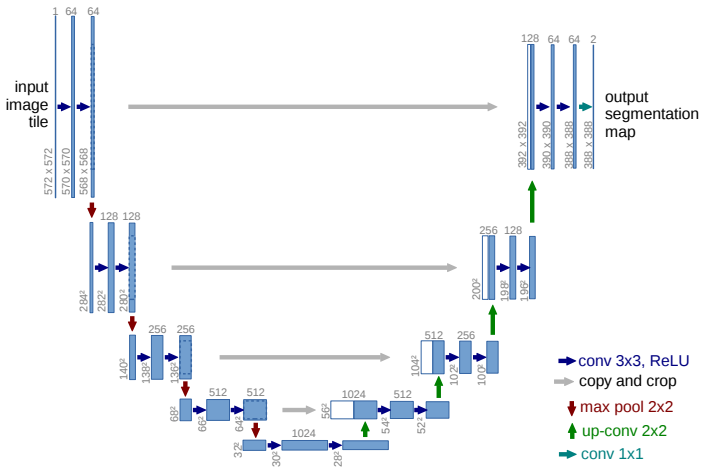

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [ ]:
unet_model = UNet().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(unet_model.parameters())

In [ ]:
train(model=unet_model,optimizer=optimizer,criterion=loss_fn,epochs=20,train_loader=train_dataloader,val_loader=valid_dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with BCEWithLogitsLoss: 0.5410745665431023


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with BCEWithLogitsLoss: 0.6583119034767151, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with BCEWithLogitsLoss: 0.37488217651844025


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with BCEWithLogitsLoss: 0.6098216474056244, avg iou: 0.19282278418540955


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with BCEWithLogitsLoss: 0.3180122449994087


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with BCEWithLogitsLoss: 0.5951044261455536, avg iou: 0.00041273640817962587


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with BCEWithLogitsLoss: 0.2995416149497032


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with BCEWithLogitsLoss: 0.5585117340087891, avg iou: 0.035066213458776474


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with BCEWithLogitsLoss: 0.28065092116594315


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with BCEWithLogitsLoss: 0.5478495210409164, avg iou: 0.20933474600315094


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with BCEWithLogitsLoss: 0.26689209043979645


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with BCEWithLogitsLoss: 0.4723070561885834, avg iou: 0.3948223888874054


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with BCEWithLogitsLoss: 0.2662276029586792


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with BCEWithLogitsLoss: 0.5046107321977615, avg iou: 0.5152297616004944


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with BCEWithLogitsLoss: 0.24414653703570366


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with BCEWithLogitsLoss: 0.4102075845003128, avg iou: 0.580750584602356


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with BCEWithLogitsLoss: 0.24774745851755142


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with BCEWithLogitsLoss: 0.3551073968410492, avg iou: 0.6442447304725647


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with BCEWithLogitsLoss: 0.24979492649435997


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with BCEWithLogitsLoss: 0.27778053283691406, avg iou: 0.6984297037124634


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with BCEWithLogitsLoss: 0.2410334348678589


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with BCEWithLogitsLoss: 0.25810497254133224, avg iou: 0.7196341753005981


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with BCEWithLogitsLoss: 0.22210276871919632


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with BCEWithLogitsLoss: 0.2918269634246826, avg iou: 0.7329169511795044


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with BCEWithLogitsLoss: 0.23049692809581757


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with BCEWithLogitsLoss: 0.2669557109475136, avg iou: 0.7377318143844604


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with BCEWithLogitsLoss: 0.2070412077009678


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with BCEWithLogitsLoss: 0.3019404262304306, avg iou: 0.6966134905815125


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with BCEWithLogitsLoss: 0.21282298490405083


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with BCEWithLogitsLoss: 0.3170323371887207, avg iou: 0.6986838579177856


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with BCEWithLogitsLoss: 0.20765161514282227


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with BCEWithLogitsLoss: 0.4358096420764923, avg iou: 0.6231347322463989


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with BCEWithLogitsLoss: 0.2014572061598301


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with BCEWithLogitsLoss: 0.5752124190330505, avg iou: 0.6223928928375244


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with BCEWithLogitsLoss: 0.19710147008299828


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with BCEWithLogitsLoss: 0.6209208369255066, avg iou: 0.6592865586280823


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with BCEWithLogitsLoss: 0.18399149179458618


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with BCEWithLogitsLoss: 0.584850400686264, avg iou: 0.6746231317520142


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with BCEWithLogitsLoss: 0.18136024102568626


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with BCEWithLogitsLoss: 0.27038048952817917, avg iou: 0.7643939256668091


{'train loss': [0.4675405025482178,
  0.31644439697265625,
  0.2930786907672882,
  0.2927587926387787,
  0.275259405374527,
  0.2502118647098541,
  0.2485222965478897,
  0.24210922420024872,
  0.2942887246608734,
  0.23358871042728424,
  0.2658632695674896,
  0.2620871663093567,
  0.2625992000102997,
  0.2357674092054367,
  0.2191590517759323,
  0.22984059154987335,
  0.18873821198940277,
  0.2311038374900818,
  0.19086898863315582,
  0.17462413012981415],
 'val_loss': [0.6583119034767151,
  0.6098216474056244,
  0.5951044261455536,
  0.5585117340087891,
  0.5478495210409164,
  0.4723070561885834,
  0.5046107321977615,
  0.4102075845003128,
  0.3551073968410492,
  0.27778053283691406,
  0.25810497254133224,
  0.2918269634246826,
  0.2669557109475136,
  0.3019404262304306,
  0.3170323371887207,
  0.4358096420764923,
  0.5752124190330505,
  0.6209208369255066,
  0.584850400686264,
  0.27038048952817917],
 'val_iou': [tensor(0., device='cuda:0'),
  tensor(0.1928, device='cuda:0'),
  tenso

In [ ]:
test(test_dataloader,unet_model,'/content/checkpoints/UNet_BCEWithLogitsLoss/best_val_loss.pt')

tensor(0.7532, device='cuda:0')

## Обучите UNet

Задание: обучите UNet на всех трех лоссах: BCE, Dice, Focal и сравните результаты с SegNet:
*   Какая модель дает лучшие значения по метрике?
*   Какая модель дает лучшие значения по лоссам?
*   Какая модель обучается быстрее?
*   Сравните визуально результаты SegNet и UNet.

Напишите развернутый ответ на вопросы.



In [ ]:
loss_fns = [nn.BCELoss(reduction='sum'),DiceLoss(mode='binary'),sigmoid_focal_loss]

for i in range(3):
    unet_model = UNet().to(device)
    loss_fn = loss_fns[i]
    optimizer = torch.optim.Adam(unet_model.parameters())
    stats = train(model=unet_model,optimizer=optimizer,criterion=loss_fn,epochs=20,train_loader=train_dataloader,val_loader=valid_dataloader)
    try:
        print(f'{unet_model._get_name()}_{loss_fn._get_name()}',test(test_dataloader,unet_model,f'/content/checkpoints/{unet_model._get_name()}_{loss_fn._get_name()}/best_val_loss.pt'))
    except:
        print(f'{unet_model._get_name()}_{loss_fn.__name__}',test(test_dataloader,unet_model,f'/content/checkpoints/{unet_model._get_name()}_{loss_fn.__name__}/best_val_loss.pt'))
    del unet_model, loss_fn, optimizer, stats

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with BCELoss: 747920.21875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with BCELoss: 1073369.5, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with BCELoss: 492878.7734375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with BCELoss: 1005936.4375, avg iou: 0.001239452394656837


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with BCELoss: 478105.6484375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with BCELoss: 962934.71875, avg iou: 0.0006623664521612227


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with BCELoss: 439906.0625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with BCELoss: 1140322.125, avg iou: 0.06250464916229248


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with BCELoss: 395223.6796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with BCELoss: 873439.9375, avg iou: 0.2925863564014435


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with BCELoss: 396894.75


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with BCELoss: 1187221.25, avg iou: 0.3736186623573303


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with BCELoss: 363873.8828125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with BCELoss: 1056201.65625, avg iou: 0.47189873456954956


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with BCELoss: 356254.609375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with BCELoss: 651446.125, avg iou: 0.5245291590690613


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with BCELoss: 344313.2109375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with BCELoss: 470208.421875, avg iou: 0.6792938709259033


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with BCELoss: 332612.671875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with BCELoss: 498091.65625, avg iou: 0.7161448001861572


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with BCELoss: 371300.796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with BCELoss: 691934.28125, avg iou: 0.6590200662612915


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with BCELoss: 307826.4453125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with BCELoss: 636786.03125, avg iou: 0.7029739618301392


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with BCELoss: 326485.0859375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with BCELoss: 426478.859375, avg iou: 0.7267753481864929


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with BCELoss: 282609.45703125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with BCELoss: 612154.625, avg iou: 0.6681748628616333


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with BCELoss: 280964.95703125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with BCELoss: 523506.8125, avg iou: 0.675340473651886


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with BCELoss: 279172.45703125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with BCELoss: 445331.21875, avg iou: 0.7754858136177063


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with BCELoss: 275698.23828125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with BCELoss: 736203.3125, avg iou: 0.6618471145629883


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with BCELoss: 256937.8046875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with BCELoss: 519929.8125, avg iou: 0.7260412573814392


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with BCELoss: 267138.6640625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with BCELoss: 574886.921875, avg iou: 0.7372537851333618


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with BCELoss: 246317.640625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with BCELoss: 489431.71875, avg iou: 0.7595946788787842
UNet_BCELoss tensor(0.7452, device='cuda:0')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with DiceLoss: 0.48430758714675903


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with DiceLoss: 0.6210248470306396, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with DiceLoss: 0.33212457597255707


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with DiceLoss: 0.4815464913845062, avg iou: 0.3545147776603699


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with DiceLoss: 0.2983618229627609


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with DiceLoss: 0.6300294399261475, avg iou: 0.22217948734760284


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with DiceLoss: 0.3027413338422775


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with DiceLoss: 0.2646663188934326, avg iou: 0.6133534908294678


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with DiceLoss: 0.2782883197069168


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with DiceLoss: 0.42542290687561035, avg iou: 0.4081624746322632


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with DiceLoss: 0.23547101020812988


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with DiceLoss: 0.38029608130455017, avg iou: 0.5989890098571777


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with DiceLoss: 0.20726284384727478


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with DiceLoss: 0.4285134971141815, avg iou: 0.38958120346069336


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with DiceLoss: 0.1992047280073166


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with DiceLoss: 0.41308069229125977, avg iou: 0.4022003412246704


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with DiceLoss: 0.17618735134601593


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with DiceLoss: 0.23921453952789307, avg iou: 0.6790209412574768


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with DiceLoss: 0.16699858009815216


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with DiceLoss: 0.2377600073814392, avg iou: 0.6766431927680969


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with DiceLoss: 0.17291446030139923


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with DiceLoss: 0.19461879134178162, avg iou: 0.7422969341278076


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with DiceLoss: 0.15383362770080566


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with DiceLoss: 0.1717948019504547, avg iou: 0.7696994543075562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with DiceLoss: 0.152920663356781


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with DiceLoss: 0.1715875267982483, avg iou: 0.7650586366653442


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with DiceLoss: 0.14080923795700073


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with DiceLoss: 0.1658196747303009, avg iou: 0.7818266153335571


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with DiceLoss: 0.1429467648267746


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with DiceLoss: 0.16603103280067444, avg iou: 0.7833811044692993


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with DiceLoss: 0.12313677370548248


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with DiceLoss: 0.18100297451019287, avg iou: 0.7552274465560913


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with DiceLoss: 0.1264243870973587


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with DiceLoss: 0.2445191740989685, avg iou: 0.6538417339324951


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with DiceLoss: 0.10730850696563721


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with DiceLoss: 0.1625908613204956, avg iou: 0.7640610337257385


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with DiceLoss: 0.1078244298696518


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with DiceLoss: 0.17796972393989563, avg iou: 0.7284196019172668


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with DiceLoss: 0.1297476440668106


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with DiceLoss: 0.14398714900016785, avg iou: 0.7856142520904541
UNet_DiceLoss tensor(0.7810, device='cuda:0')


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1: avg train loss with sigmoid_focal_loss: 107997.958984375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1: avg val loss with sigmoid_focal_loss: 141299.265625, avg iou: 0.0


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2: avg train loss with sigmoid_focal_loss: 58249.2392578125


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2: avg val loss with sigmoid_focal_loss: 407174.890625, avg iou: 0.4020485281944275


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3: avg train loss with sigmoid_focal_loss: 50491.921875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3: avg val loss with sigmoid_focal_loss: 11718245.0, avg iou: 0.33601146936416626


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4: avg train loss with sigmoid_focal_loss: 41436.388671875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4: avg val loss with sigmoid_focal_loss: 6444530.0, avg iou: 0.34108904004096985


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5: avg train loss with sigmoid_focal_loss: 42148.0771484375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5: avg val loss with sigmoid_focal_loss: 4945889.5, avg iou: 0.3483343720436096


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6: avg train loss with sigmoid_focal_loss: 39295.71826171875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6: avg val loss with sigmoid_focal_loss: 1209278.8125, avg iou: 0.41467368602752686


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7: avg train loss with sigmoid_focal_loss: 40936.5625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7: avg val loss with sigmoid_focal_loss: 67089.15234375, avg iou: 0.48260173201560974


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8: avg train loss with sigmoid_focal_loss: 38311.0556640625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8: avg val loss with sigmoid_focal_loss: 62481.287109375, avg iou: 0.43988722562789917


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9: avg train loss with sigmoid_focal_loss: 37425.9755859375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9: avg val loss with sigmoid_focal_loss: 59234.0234375, avg iou: 0.41130369901657104


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10: avg train loss with sigmoid_focal_loss: 34220.9716796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10: avg val loss with sigmoid_focal_loss: 71670.912109375, avg iou: 0.4066292345523834


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11: avg train loss with sigmoid_focal_loss: 32223.08984375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11: avg val loss with sigmoid_focal_loss: 60521.287109375, avg iou: 0.670183539390564


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12: avg train loss with sigmoid_focal_loss: 35374.84130859375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12: avg val loss with sigmoid_focal_loss: 55216.326171875, avg iou: 0.6985777616500854


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13: avg train loss with sigmoid_focal_loss: 30675.40576171875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13: avg val loss with sigmoid_focal_loss: 74529.25, avg iou: 0.67914217710495


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14: avg train loss with sigmoid_focal_loss: 33679.23583984375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14: avg val loss with sigmoid_focal_loss: 52705.8515625, avg iou: 0.7445418834686279


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15: avg train loss with sigmoid_focal_loss: 30270.4365234375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15: avg val loss with sigmoid_focal_loss: 59493.7109375, avg iou: 0.6989408135414124


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16: avg train loss with sigmoid_focal_loss: 27563.068359375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16: avg val loss with sigmoid_focal_loss: 42516.73828125, avg iou: 0.695733904838562


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17: avg train loss with sigmoid_focal_loss: 31754.67724609375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17: avg val loss with sigmoid_focal_loss: 44096.4892578125, avg iou: 0.7103515863418579


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18: avg train loss with sigmoid_focal_loss: 26834.927734375


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18: avg val loss with sigmoid_focal_loss: 39015.052734375, avg iou: 0.7406370639801025


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19: avg train loss with sigmoid_focal_loss: 32249.1591796875


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19: avg val loss with sigmoid_focal_loss: 92299.671875, avg iou: 0.6809694766998291


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20: avg train loss with sigmoid_focal_loss: 28643.67431640625


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20: avg val loss with sigmoid_focal_loss: 100763.15625, avg iou: 0.7651370763778687
UNet_sigmoid_focal_loss tensor(0.7193, device='cuda:0')


BCELoss: 02:05, iou 0.7452

DiceLoss: 02:06, iou 0.7810

sigmoid_focal_loss: 02:06, iou 0.7193


Быстрее всех обучение было с BCELoss функции, хотя вцелом разница во времени обучение небольшая в отличие от показателя iou. Наибольшее значение метрики при использовании DiceLoss функции